<a href="https://colab.research.google.com/github/Kl195/123/blob/main/IDS_(Isolation_Forest%2C_Autoencoder%2C_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrusion Detection System for In-Vehicle Networks Using AI

* * *

This notebook demonstrates the development of an Intrusion Detection System (IDS) for In-Vehicle Networks (IVN) using Artificial Intelligence techniques. The goal is to detect anomalies in CAN bus traffic that may indicate a cyberattack. The process involves loading and preprocessing raw CAN data, training different anomaly detection models, and evaluating their performance.

### Inspecting Raw Data

We'll start by inspecting a small sample of the raw data from each dataset file (`RPM_dataset.csv`, `gear_dataset.csv`, `DoS_dataset.csv`, and `Fuzzy_dataset.csv`). This helps us see the original format, delimiters, and potential inconsistencies before any cleaning is applied.

In [ ]:
import pandas as pd

file_paths = [
    "/content/RPM_dataset.csv",
    "/content/gear_dataset.csv",
    "/content/DoS_dataset.csv",
    "/content/Fuzzy_dataset.csv"
]

sample_size = 5  # Number of lines to read from the beginning of each file

for file_path in file_paths:
    print(f"--- Raw data sample from: {file_path} ---")
    try:
        # Read a small number of lines to inspect the raw format
        with open(file_path, 'r') as f:
            for i in range(sample_size):
                line = f.readline()
                if not line:
                    break
                print(line.strip())
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    print("-" * (len(file_path) + 28))

--- Raw data sample from: /content/RPM_dataset.csv ---
1478191030.045114,0316,8,05,22,68,09,22,20,00,75,R
1478191030.045353,018f,8,fe,3b,00,00,00,3c,00,00,R
1478191030.045580,0260,8,19,22,22,30,ff,8f,6e,3f,R
1478191030.045815,02a0,8,60,00,83,1d,96,02,bd,00,R
1478191030.046043,0329,8,dc,b8,7e,14,11,20,00,14,R
----------------------------------------------------
--- Raw data sample from: /content/gear_dataset.csv ---
1478193190.056566,0140,8,00,00,00,00,10,29,2a,24,R
1478193190.056817,02c0,8,15,00,00,00,00,00,00,00,R
1478193190.057058,0350,8,05,20,44,68,77,00,00,7e,R
1478193190.057304,0370,8,00,20,00,00,00,00,00,00,R
1478193190.057542,043f,8,10,40,60,ff,78,c4,08,00,R
-----------------------------------------------------
--- Raw data sample from: /content/DoS_dataset.csv ---
1478198376.389427,0316,8,05,21,68,09,21,21,00,6f,R
1478198376.389636,018f,8,fe,5b,00,00,00,3c,00,00,R
1478198376.389864,0260,8,19,21,22,30,08,8e,6d,3a,R
1478198376.390096,02a0,8,64,00,9a,1d,97,02,bd,00,R
1478198376.39

## 1. Data Inspection and Preparation

Before diving into model training, it's crucial to understand the raw data format and clean it for consistent processing. CAN bus data can be noisy and have irregular structures, requiring careful handling.

### Cleaning and Standardizing Data

The raw datasets have no headers and irregular column structures. The following code implements a robust cleaning function to standardize the data. This function handles missing values, ensures a consistent number of data bytes (D0-D7), converts hexadecimal values to integers, and assigns a label (Normal or Attack) to each entry. The cleaned datasets are then concatenated and shuffled to create a single, unified dataset for training and evaluation.

In [ ]:
# --- SECTION 1: Setup ---
import pandas as pd
import re
from google.colab import files

# --- SECTION 2.1 (optional): Upload Raw CAN Datasets ---
#uploaded = files.upload()  # Upload DoS_dataset.csv, Fuzzy_dataset.csv, RPM_dataset.csv, gear_dataset.csv

# --- SECTION 2.2: Load Raw Datasets (no headers, irregular columns) ---
dos_df = pd.read_csv("DoS_dataset.csv", header=None, engine='python')
fuzzy_df = pd.read_csv("Fuzzy_dataset.csv", header=None, engine='python')
rpm_df = pd.read_csv("RPM_dataset.csv", header=None, engine='python')
gear_df = pd.read_csv("gear_dataset.csv", header=None, engine='python')

# --- SECTION 3: Safe Cleaning Function ---
def clean_and_standardize_can_df(df_raw, label):
    """
    Cleans a raw CAN dataset and assigns normal (0) or attack (1) labels.
    Ensures D0-D7 are always 8 bytes, and handles missing or corrupted entries.
    """
    df_raw = df_raw.astype(str)  # Ensure all data is string
    cleaned_rows = []

    for index, row in df_raw.iterrows():
        row_values = list(row.values)

        # Pad short rows to expected 12 columns
        if len(row_values) < 12:
            row_values += [''] * (12 - len(row_values))

        # Extract fields
        timestamp = row_values[0]
        msg_id = row_values[1]
        dlc = row_values[2]
        data_bytes = row_values[3:11]  # D0 to D7
        flag = row_values[11]  # R or T

        # Ensure 8 data bytes
        while len(data_bytes) < 8:
            data_bytes.append('00')

        # Safe hex to int conversion
        def hex_to_int(x):
            x = x.strip()
            return int(x, 16) if re.fullmatch(r'[0-9a-fA-F]{1,2}', x) else 0

        try:
            row_cleaned = {
                'Timestamp': float(timestamp),
                'ID': int(msg_id, 16) if re.fullmatch(r'[0-9a-fA-F]+', msg_id.strip()) else 0,
                'D0': hex_to_int(data_bytes[0]),
                'D1': hex_to_int(data_bytes[1]),
                'D2': hex_to_int(data_bytes[2]),
                'D3': hex_to_int(data_bytes[3]),
                'D4': hex_to_int(data_bytes[4]),
                'D5': hex_to_int(data_bytes[5]),
                'D6': hex_to_int(data_bytes[6]),
                'D7': hex_to_int(data_bytes[7]),
                'Label': label
            }
            cleaned_rows.append(row_cleaned)
        except:
            continue  # Skip corrupted rows

    return pd.DataFrame(cleaned_rows)

# --- SECTION 4: Preprocess and Label Each Dataset ---
dos_clean = clean_and_standardize_can_df(dos_df, label=1)
fuzzy_clean = clean_and_standardize_can_df(fuzzy_df, label=1)
rpm_clean = clean_and_standardize_can_df(rpm_df, label=0)
gear_clean = clean_and_standardize_can_df(gear_df, label=0)

# --- SECTION 5: Combine and Shuffle ---
full_df = pd.concat([dos_clean, fuzzy_clean, rpm_clean, gear_clean], ignore_index=True)
full_df = full_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# --- SECTION 6: Save Cleaned Dataset --- (Optional)
#full_df.to_csv("Cleaned_CAN_Dataset.csv", index=False)
#files.download("Cleaned_CAN_Dataset.csv")

# --- OPTIONAL: Preview the dataset ---
print("✅ Cleaned dataset preview:")
print(full_df.head())
print("\nColumns:", full_df.columns.tolist())
print("Total samples:", len(full_df))
print("Label distribution:\n", full_df['Label'].value_counts())


✅ Cleaned dataset preview:
      Timestamp   ID   D0  D1   D2   D3   D4   D5   D6   D7  Label
0  1.478191e+09  880    0  32    0    0    0    0    0    0      0
1  1.478201e+09  672  100   0  154   29  151    2  189    0      1
2  1.478201e+09  848    5  32   20  104  118    0    0   47      1
3  1.478201e+09  848    5  32   84  104  119    0    0  110      0
4  1.478193e+09  339    0  33   16  255    0  255    0    0      0

Columns: ['Timestamp', 'ID', 'D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'Label']
Total samples: 16569475
Label distribution:
 Label
0    9064844
1    7504631
Name: count, dtype: int64


## 2. Anomaly Detection Model Training

With the cleaned and prepared dataset, we can now train different AI models for anomaly detection. We will explore three different approaches: Isolation Forest, a traditional machine learning algorithm; and two deep learning models, a standard Autoencoder and an LSTM Autoencoder.

### *Before training AI models, we need to load the dataset after cleaned.
Load Cleaned Dataset

We load the `Cleaned_CAN_Dataset.csv` file, which contains the combined and preprocessed data from all raw datasets. This dataset includes features extracted from the CAN messages and a corresponding label indicating whether the message is "Normal" (0) or an "Attack" (1).

In [5]:
# Upload and load the cleaned dataset
from google.colab import files
import pandas as pd
#uploaded = files.upload()
df = pd.read_csv("Cleaned_CAN_Dataset.csv")

### 2.1. Train Isolation Forest Model

The Isolation Forest is an ensemble machine learning algorithm that works by isolating anomalies rather than profiling normal data. It's often effective for detecting outliers in high-dimensional datasets. We train the model on the preprocessed data and evaluate its performance using a classification report and confusion matrix. The `contamination` parameter is set based on the observed proportion of attack samples in the dataset.

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Features and labels
features = ['ID', 'D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7']
X = df[features]
y = df['Label']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Isolation Forest
# Adjusted contamination based on the label distribution observed in the cleaned data preview
# where attack samples were approximately 7.5 million out of 16.5 million total.
# This is roughly 45%, so setting contamination closer to this value might be more appropriate.
# Let's use 0.45 as an initial estimate.
iso_model = IsolationForest(contamination=0.45, random_state=42)
iso_model.fit(X_train)

# Predict
# The Isolation Forest predicts -1 for anomalies and 1 for normal.
# We need to map this to our label system (0 for normal, 1 for anomaly).
y_pred_iso = iso_model.predict(X_test)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

# Store performance
print("🔍 Isolation Forest Results:")
print(classification_report(y_test, y_pred_iso))
print(confusion_matrix(y_test, y_pred_iso))

🔍 Isolation Forest Results:
              precision    recall  f1-score   support

           0       0.55      0.56      0.55   1812518
           1       0.46      0.46      0.46   1501377

    accuracy                           0.51   3313895
   macro avg       0.51      0.51      0.51   3313895
weighted avg       0.51      0.51      0.51   3313895

[[1007288  805230]
 [ 816319  685058]]


### 2.2. Train Autoencoder Model

An Autoencoder is a type of neural network used for unsupervised learning. It learns to compress data into a lower-dimensional representation (encoding) and then reconstruct it (decoding). Anomalies, being different from normal data, will typically have higher reconstruction errors. We train a standard dense Autoencoder and use a threshold on the reconstruction error to classify messages as normal or anomalous.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import numpy as np

# Define architecture
input_dim = X_train.shape[1]
encoding_dim = 5

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# Train
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, shuffle=True, validation_split=0.1, verbose=0)

# Predict and score
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 90)
y_pred_ae = [1 if val > threshold else 0 for val in mse]

# Store performance
print("🔍 Autoencoder Results:")
print(classification_report(y_test, y_pred_ae))
print(confusion_matrix(y_test, y_pred_ae))


103560/103560 ━━━━━━━━━━━━━━━━━━━━ 116s 1ms/step
🔍 Autoencoder Results:
              precision    recall  f1-score   support

           0       0.56      0.93      0.70   1812518
           1       0.61      0.13      0.22   1501377

    accuracy                           0.57   3313895
   macro avg       0.59      0.53      0.46   3313895
weighted avg       0.58      0.57      0.48   3313895

[[1682953  129565]
 [1300404  200973]]


### 2.3. Train LSTM Autoencoder Model

Given the sequential nature of CAN bus traffic, an LSTM (Long Short-Term Memory) Autoencoder can be a suitable model as it can capture temporal dependencies. This model is similar to the standard Autoencoder but uses LSTM layers to process sequences of data. We train the LSTM Autoencoder and again use reconstruction error for anomaly detection.

In [6]:
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Reshape for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM Autoencoder
timesteps = X_train_lstm.shape[1]
features_lstm = X_train_lstm.shape[2]

inputs = Input(shape=(timesteps, features_lstm))
encoded = LSTM(32, activation="relu", return_sequences=False)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(32, activation="relu", return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(features_lstm))(decoded)

lstm_autoencoder = Model(inputs, decoded)
lstm_autoencoder.compile(optimizer="adam", loss="mse")

# Train
lstm_autoencoder.fit(X_train_lstm, X_train_lstm, epochs=10, batch_size=64, validation_split=0.1, verbose=0)

# Predict and score
reconstructions_lstm = lstm_autoencoder.predict(X_test_lstm)
mse_lstm = np.mean(np.power(X_test_lstm - reconstructions_lstm, 2), axis=(1, 2))
threshold_lstm = np.percentile(mse_lstm, 90)
y_pred_lstm = [1 if e > threshold_lstm else 0 for e in mse_lstm]

# Store performance
print("🔍 LSTM Autoencoder Results:")
print(classification_report(y_test, y_pred_lstm))
print(confusion_matrix(y_test, y_pred_lstm))


103560/103560 ━━━━━━━━━━━━━━━━━━━━ 150s 1ms/step
🔍 LSTM Autoencoder Results:
              precision    recall  f1-score   support

           0       0.54      0.89      0.67   1812518
           1       0.40      0.09      0.15   1501377

    accuracy                           0.53   3313895
   macro avg       0.47      0.49      0.41   3313895
weighted avg       0.48      0.53      0.43   3313895

[[1614282  198236]
 [1368225  133152]]


## 3. Model Evaluation and Visualization

After training the models, it's important to evaluate their performance and compare them to understand which approach is most effective for this task. Visualizations can provide a clear overview of the models' strengths and weaknesses.

### 3.1. Visualize CAN Message Behavior (Raw Bytes)

Before looking at model performance, a quick visualization of the raw data bytes over a short time window can provide insights into the nature of the CAN traffic and how different bytes change over time. This helps in understanding the data the models are processing.

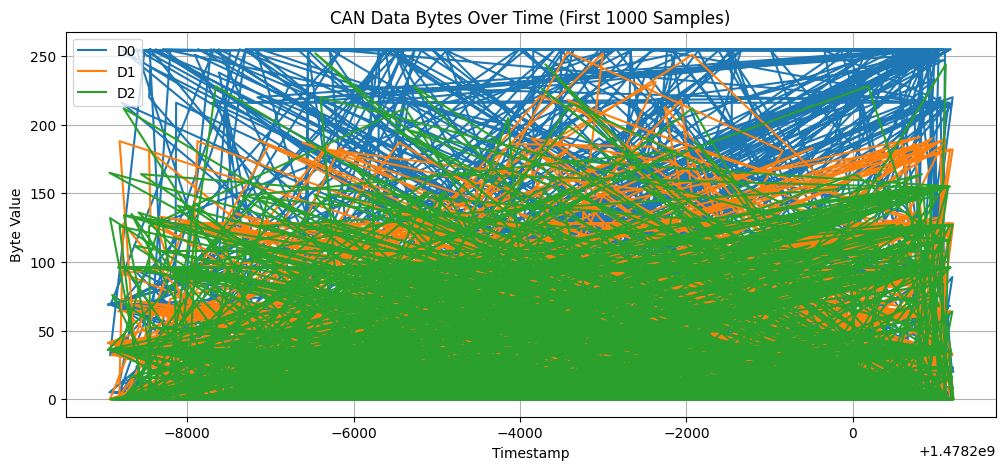

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df['Timestamp'][:1000], df['D0'][:1000], label='D0')
plt.plot(df['Timestamp'][:1000], df['D1'][:1000], label='D1')
plt.plot(df['Timestamp'][:1000], df['D2'][:1000], label='D2')
plt.title('CAN Data Bytes Over Time (First 1000 Samples)')
plt.xlabel('Timestamp')
plt.ylabel('Byte Value')
plt.legend()
plt.grid(True)
plt.show()


### 3.2. Visualizing Feature Differences with a Heatmap

To better understand the differences between normal and attack messages, we can visualize the average values of the data bytes (D0-D7) for each category. A heatmap is an excellent tool for this, as it provides a clear visual representation of how the byte values differ between normal and malicious traffic. This can help confirm that there are indeed patterns in the data that our machine learning models can learn.

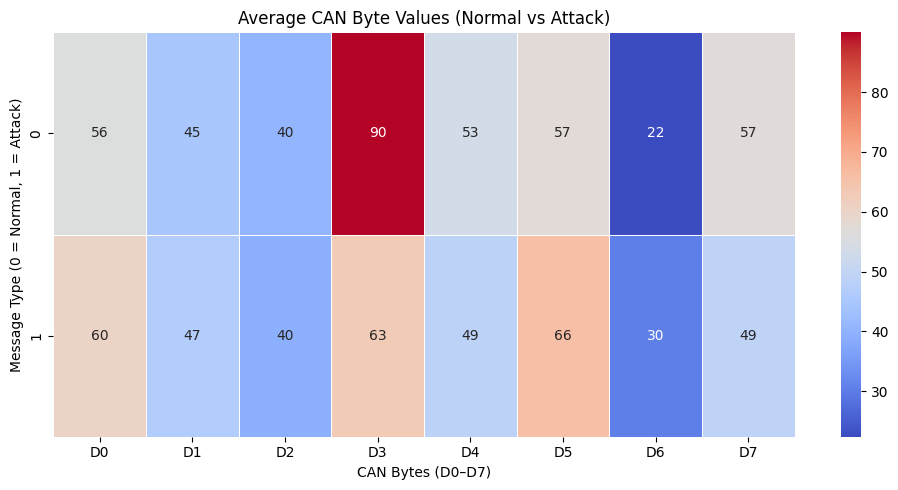

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load cleaned CAN dataset
df = pd.read_csv("Cleaned_CAN_Dataset.csv")  # replace with the correct path if needed

# Check and filter required columns
byte_cols = ['D0','D1','D2','D3','D4','D5','D6','D7','Label']
df = df[[*byte_cols]].dropna()

# Compute mean byte values by label
heat_data = df.groupby("Label")[['D0','D1','D2','D3','D4','D5','D6','D7']].mean()

# Plot heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(heat_data, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Average CAN Byte Values (Normal vs Attack)")
plt.xlabel("CAN Bytes (D0–D7)")
plt.ylabel("Message Type (0 = Normal, 1 = Attack)")
plt.tight_layout()
plt.show()


### 3.3. Visualize Performance Comparison of All Models

This section visualizes the key performance metrics (Accuracy, Precision, Recall, and F1-Score) for the trained Isolation Forest, Autoencoder, and LSTM Autoencoder models. A bar chart is used to provide a clear comparison of how each model performed in detecting anomalies. This visualization helps in identifying the most promising model for further optimization or deployment.

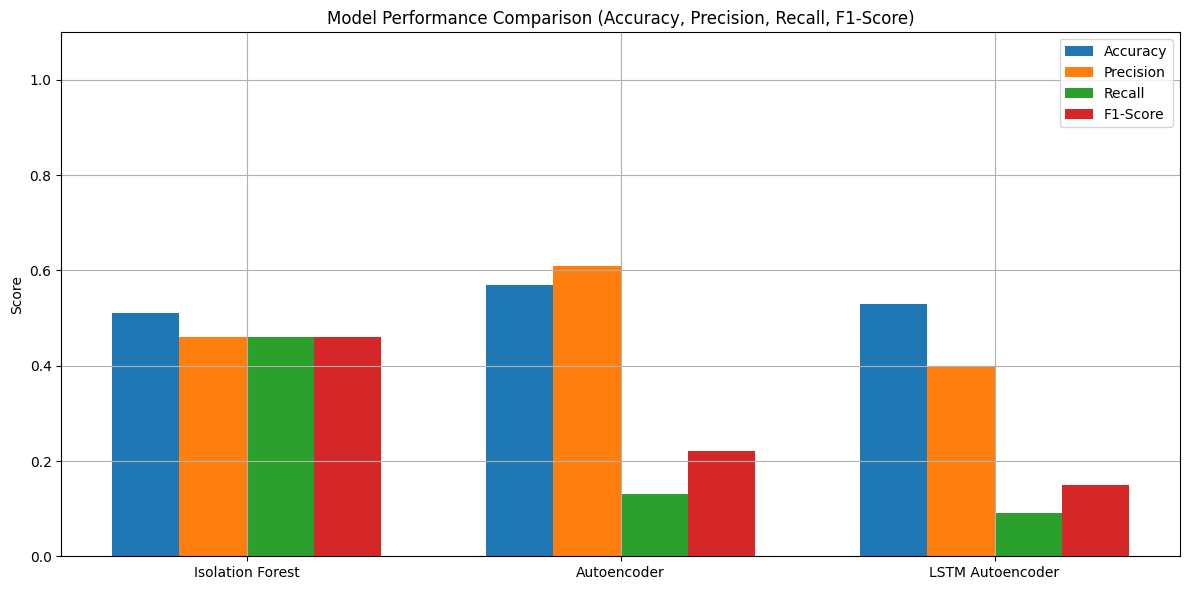

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load the saved predictions
data = np.load('model_predictions.npz')
y_pred_iso = data['y_pred_iso']
y_pred_ae = data['y_pred_ae']
y_pred_lstm = data['y_pred_lstm']
y_test = data['y_test']

# --- Visualize Performance ---
models = ['Isolation Forest', 'Autoencoder', 'LSTM Autoencoder']
accuracies = [
    accuracy_score(y_test, y_pred_iso),
    accuracy_score(y_test, y_pred_ae),
    accuracy_score(y_test, y_pred_lstm)
]
precisions = [
    precision_score(y_test, y_pred_iso),
    precision_score(y_test, y_pred_ae),
    precision_score(y_test, y_pred_lstm)
]
recalls = [
    recall_score(y_test, y_pred_iso),
    recall_score(y_test, y_pred_ae),
    recall_score(y_test, y_pred_lstm)
]
f1_scores = [
    f1_score(y_test, y_pred_iso),
    f1_score(y_test, y_pred_ae),
    f1_score(y_test, y_pred_lstm)
]

x = np.arange(len(models))
width = 0.18

plt.figure(figsize=(12, 6))
plt.bar(x - width*1.5, accuracies, width, label='Accuracy')
plt.bar(x - width/2, precisions, width, label='Precision')
plt.bar(x + width/2, recalls, width, label='Recall')
plt.bar(x + width*1.5, f1_scores, width, label='F1-Score')

plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Model Performance Comparison (Accuracy, Precision, Recall, F1-Score)")
plt.legend()
plt.grid(True)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

## Conclusion

Based on the performance comparison, we can draw conclusions about the effectiveness of each AI model for this specific in-vehicle network intrusion detection task. Further steps could involve fine-tuning the best-performing model, exploring ensemble methods, or investigating more advanced techniques to improve detection accuracy and reduce false positives.